# **Redes Neuronales**

**Equipo:**
* Gabriel Frisancho
* Jesús Niño
* Adrian Sandoval
* Diana Chavez

## **Objetivo**

Implementar manualmente el backpropagation en un Perceptrón Multicapa (MLP) para demostrar el Teorema de Aproximación Universal.  
Se inicia con la clásica función XOR y se avanza hacia un problema real de regresión con el dataset **Airfoil Self‑Noise** de la NASA.  
El reto pone a prueba la capacidad de los MLP para aproximar relaciones no lineales *sin ayuda de librerías de derivación* y los anima a experimentar con arquitecturas bajo un límite de 5 000 parámetros.

## **Tareas**

1. **Validación con XOR**  
   - Construir y entrenar un MLP desde cero para reproducir la tabla de verdad XOR.  
   - Evaluar el desempeño con Error Cuadrático Medio (MSE) y mostrar el límite de decisión.

2. **Predicción de ruido aerodinámico (Airfoil)**  
   - Preprocesar y dividir el dataset 70/15/15.  
   - Diseñar la arquitectura, entrenar y optimizar el MLP para minimizar **RMSE**.  
   - Mantener el total de parámetros **< 5 000**.  
   - Incluir verificación de gradiente numérico en 10 muestras aleatorias.

3. **Análisis y comparación**  
   - Graficar las curvas de entrenamiento/validación.  
   - Comparar contra una Regresión Lineal base.  
   - Discutir evidencias que respalden el Teorema de Aproximación Universal.

## **Entregables**

1. **Canvas**  
   - Notebook (.ipynb) con código, verificación de gradientes, curvas y análisis crítico.

#### **Importar librerias y dataset**

In [28]:
import numpy as np
import urllib.request, os, copy, math, random
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"
fname = "airfoil_self_noise.dat"
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)

data = np.loadtxt(fname)
X = data[:, :5]
y = data[:, 5:]

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (1503, 5) (1503, 1)


In [29]:
# Train / val / test split
rng = np.random.default_rng(42)
idx = rng.permutation(len(X))
n_train = int(0.7 * len(X))
n_val = int(0.85 * len(X))
train_idx, val_idx, test_idx = idx[:n_train], idx[n_train:n_val], idx[n_val:]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Normalize
x_mean, x_std = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True)
y_mean, y_std = y_train.mean(), y_train.std()

def norm_x(x): return (x - x_mean) / x_std
def norm_y(t): return (t - y_mean) / y_std
def denorm_y(tn): return tn * y_std + y_mean

X_train, X_val, X_test = map(norm_x, (X_train, X_val, X_test))
y_train_n, y_val_n, y_test_n = map(norm_y, (y_train, y_val, y_test))
print("Splits:", X_train.shape, X_val.shape, X_test.shape)

Splits: (1052, 5) (225, 5) (226, 5)


## **1. Capas bases**

In [30]:
# CODE HERE for backward pass

# f0, f1, f2
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2.0 / in_dim)
        self.b = np.zeros((1, out_dim))
    def forward(self, x):
        self.x = x
        return x @ self.W + self.b
    def backward(self, d_out):
        self.grad_W = self.x.T @ d_out
        self.grad_b = np.sum(d_out, axis=0, keepdims=True)
        return d_out @ self.W.T

# h0, h1, h2, ....
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
    def backward(self, d_out):
        return d_out * self.mask

# error
class MSELoss:
    def forward(self, pred, target):
        self.diff = pred - target
        return np.mean(self.diff ** 2)
    def backward(self):
        n = np.prod(self.diff.shape)
        return 2 * self.diff / n

# **2. Red MLP**

In [31]:
class MLP:
    def __init__(self, dims):
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(Linear(dims[i], dims[i+1])) #fi
            self.layers.append(ReLU()) # hi
        self.layers.append(Linear(dims[-2], dims[-1]))

    # CODE HERE (forward, backward pass)
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, d_out):
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out

    @property
    def n_params(self):
        total = 0
        for l in self.layers:
            if isinstance(l, Linear):
                total += l.W.size + l.b.size
        return total

# **3. Gradient check**

In [32]:
def grad_check(model, x, y, eps=1e-5, tol=1e-4):
    loss_fn = MSELoss()
    pred = model.forward(x)
    loss = loss_fn.forward(pred, y)
    grad = loss_fn.backward()
    model.backward(grad)
    lin = next(l for l in model.layers if isinstance(l, Linear))
    i, j = np.random.randint(lin.W.shape[0]), np.random.randint(lin.W.shape[1])
    orig = lin.W[i, j]
    lin.W[i, j] = orig + eps
    plus = loss_fn.forward(model.forward(x), y)
    lin.W[i, j] = orig - eps
    minus = loss_fn.forward(model.forward(x), y)
    lin.W[i, j] = orig
    num_grad = (plus - minus) / (2*eps)
    ana_grad = lin.grad_W[i, j]
    rel_err = abs(num_grad - ana_grad) / max(1e-8, abs(num_grad)+abs(ana_grad))
    print('rel error', rel_err)
    return rel_err < tol

tmp = MLP([5,8,4,1])
grad_check(tmp, X_train[:10], y_train_n[:10])

rel error 6.576063549816381e-11


np.True_

# **4. Entrenamiento**

In [33]:
dims = [5, 64, 32, 16, 1]
lr = 0.01
epochs = 500
batch = 64
model = MLP(dims)
print('Parámetros totales:', model.n_params)
loss_fn = MSELoss()
train_hist, val_hist = [], []

for ep in range(1, epochs + 1):
    perm = np.random.permutation(len(X_train))
    X_train_shuff = X_train[perm]
    y_train_shuff = y_train_n[perm]

    losses = []
    for i in range(0, len(X_train), batch):
        xb = X_train_shuff[i:i+batch]
        yb = y_train_shuff[i:i+batch]

        pred = model.forward(xb)
        loss = loss_fn.forward(pred, yb)
        losses.append(loss)

        d_out = loss_fn.backward()
        model.backward(d_out)

        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.W -= lr * layer.grad_W
                layer.b -= lr * layer.grad_b

    train_hist.append(np.mean(losses))

    pred_val = model.forward(X_val)
    val_loss = loss_fn.forward(pred_val, y_val_n)
    val_hist.append(val_loss)

    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep:03d} | Train Loss: {train_hist[-1]:.6f} | Val Loss: {val_hist[-1]:.6f}")


Parámetros totales: 3009
Epoch 001 | Train Loss: 1.021700 | Val Loss: 0.648392
Epoch 010 | Train Loss: 0.331228 | Val Loss: 0.293321
Epoch 020 | Train Loss: 0.290984 | Val Loss: 0.275859
Epoch 030 | Train Loss: 0.266829 | Val Loss: 0.277603
Epoch 040 | Train Loss: 0.253785 | Val Loss: 0.268409
Epoch 050 | Train Loss: 0.238616 | Val Loss: 0.256435
Epoch 060 | Train Loss: 0.229688 | Val Loss: 0.249569
Epoch 070 | Train Loss: 0.210159 | Val Loss: 0.237990
Epoch 080 | Train Loss: 0.209409 | Val Loss: 0.242793
Epoch 090 | Train Loss: 0.190238 | Val Loss: 0.244098
Epoch 100 | Train Loss: 0.179723 | Val Loss: 0.241719
Epoch 110 | Train Loss: 0.175873 | Val Loss: 0.225253
Epoch 120 | Train Loss: 0.194084 | Val Loss: 0.275581
Epoch 130 | Train Loss: 0.178197 | Val Loss: 0.234519
Epoch 140 | Train Loss: 0.171489 | Val Loss: 0.238168
Epoch 150 | Train Loss: 0.163477 | Val Loss: 0.215284
Epoch 160 | Train Loss: 0.153887 | Val Loss: 0.203177
Epoch 170 | Train Loss: 0.167838 | Val Loss: 0.202799
Epo

# **5. XOR Validation**

In [34]:
# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# split into train/val
X_train, X_val = X, X
y_train_n, y_val_n = y, y

# model setup
dims = [2, 8, 4, 1]
lr = 0.1
epochs = 5000
batch = 4

model = MLP(dims)
print('Parámetros totales:', model.n_params)
loss_fn = MSELoss()
train_hist, val_hist = [], []

for ep in range(1, epochs + 1):
    pred = model.forward(X_train)
    loss = loss_fn.forward(pred, y_train_n)
    d_out = loss_fn.backward()
    model.backward(d_out)
    for layer in model.layers:
        if isinstance(layer, Linear):
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
    train_hist.append(loss)

    pred_val = model.forward(X_val)
    val_loss = loss_fn.forward(pred_val, y_val_n)
    val_hist.append(val_loss)

    if ep % 500 == 0 or ep == 1:
        print(f"Epoch {ep:04d} | Train Loss: {loss:.6f} | Val Loss: {val_loss:.6f}")

# test prediction
pred_final = model.forward(X)
print("\nPredictions:")
print(np.round(pred_final, 3))

Parámetros totales: 65
Epoch 0001 | Train Loss: 1.258542 | Val Loss: 0.227791
Epoch 0500 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 1000 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 1500 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 2000 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 2500 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 3000 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 3500 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 4000 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 4500 | Train Loss: 0.166667 | Val Loss: 0.166667
Epoch 5000 | Train Loss: 0.166667 | Val Loss: 0.166667

Predictions:
[[0.333]
 [0.333]
 [1.   ]
 [0.333]]


# **6. Evaluación**

In [36]:
dims = [5, 64, 32, 16, 1]
model = MLP(dims)
te_pred = model.forward(X_test)
test_rmse = np.sqrt(np.mean((denorm_y(te_pred)-y_test)**2))
print('Test RMSE:', test_rmse)

Test RMSE: 10.400862602794852


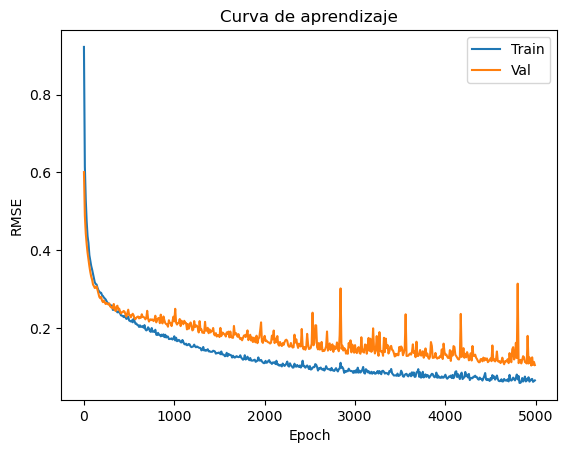

In [ ]:
plt.plot(np.arange(len(train_hist))*10+1, train_hist, label='Train')
plt.plot(np.arange(len(val_hist))*10+1, val_hist, label='Val')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('Curva de aprendizaje')
plt.show()

# **7. Análisis crítico**
- Discute influencia de arquitectura, overfitting, Universal Approximation, etc.